# Manifold Learning from neighborhoods

In [4]:
import numpy as np
import os, random

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=8)
mpl.rc('xtick', labelsize=8)
mpl.rc('ytick', labelsize=8)
markersize = 10

np.random.seed(4)

In [5]:
def palette(M):
    range1, range2 = 255./(M.shape[0]-1), 255./(M.shape[1]-1)
    y = np.zeros((M.shape[0],M.shape[1],3))
    for i in range(M.shape[0]):
        for ii in range(M.shape[1]):
            r = i*range1
            g = ii*range2
            b = (M.shape[1]-ii-1)*range2
            color = np.array([r,g,b])
            y[i,ii] = color
    y[y>1.] == 1
    y[y<0.] == 0
    return y

def plotPalette(y, t="Colors are linked to location"):
    plt.figure(figsize=(y.shape[0]*0.25, y.shape[1]*0.25))
    plt.title(t, fontsize=10)
    plt.imshow(y)
    
def plotPalettes(l, titles, rows=1, cols=1, size=(10,4)):
    for row in range(rows):
        plt.figure(figsize=size)
        for subplot, title, X_red in zip([int(f"1{cols}{i}") for i in range(1,cols+1)], titles[row*cols:(row+1)*cols], l[row*cols:(row+1)*cols]):
            plt.subplot(subplot)
            plt.title(title, fontsize=10)
            plt.imshow(X_red)
        plt.show()

## 1. Generate a dataset

### Define the drawing sheet, the surface of representation of the graph nodes

In [68]:
N = 16
M = np.arange(N**2)
np.random.shuffle(M)
M = M.reshape(N,-1)
print (M)

[[249 201 114 254   6  77 134   5 132  42 252 124 244 207 126 186]
 [170 208 218 200 245 234  55 199  53 190 161 109  66  99 216 182]
 [171  29  15 112  39  10 228 111  34 122 138  58 226  46 147 183]
 [168  17 119  92 223 136  60 236  70  11   7  33 227 151 153 209]
 [230 237 232 221  80 156  19  56  32  37 169  49 167  87 181  18]
 [ 91 108 222 242 103 173 214  54 131 176 145 128 123 239  79 194]
 [  9  97  85 233 102 220 225 229 172 250  48 120 203  59 121  62]
 [ 93   8  28 104 188 162 154 160  22  98 137  90  47  65  76 231]
 [149  82 185 165 198 105   4 219 166  57 247  95  69 148  73  64]
 [150 116  89 118  27 152 163  36 140 100 158 180 107  72 135 130]
 [175 213 243  75  12 144  84 251  81 238  86 157   0 143 193 159]
 [211 133 217 246 241 141  16 106 117  45  78 204 248 189 195  52]
 [  3 146  94  61  38 101 155  83  67 139  23  68 205 125  44 178]
 [ 30 129  24 212 255 196 164 215 206   1 179 192  51  20  50  63]
 [174  74 115  14 240  41 235  71  31 127  26 253 224  21 184 

### Allocate colors to locations, define a clipping mask

(16, 16, 3)


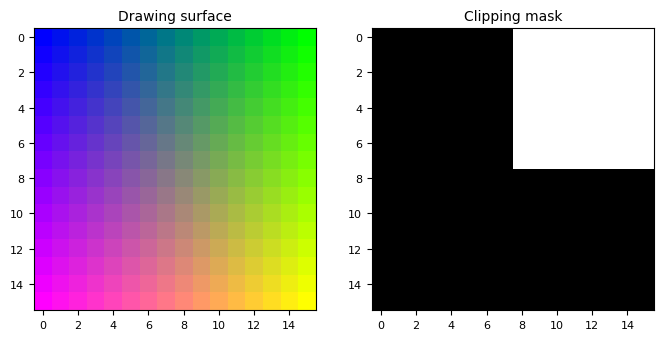

In [89]:
colors = palette(M)
print (colors.shape)
colorsMap = [[colors[i,ii][0]/255.,colors[i,ii][1]/255.,colors[i,ii][2]/255.] for ii in range(colors.shape[1]) for i in range(colors.shape[0])]

Shape = np.ones(M.shape).astype(bool)
Shape[:8,8:] = 0
shape_palette = np.stack([~Shape, ~Shape, ~Shape], axis=-1).astype(float)

exclude = M[~Shape].flatten().tolist()
Pick_shape = np.ones(M.shape).astype(bool)
Pick_shape[:8,8-2:] = 0
Pick_shape[-2:,:] = 0
Pick_shape[:,-2:] = 0
Pick_list = M[Pick_shape].flatten().tolist()

plotPalettes([colors.astype(int), shape_palette], ["Drawing surface", "Clipping mask"], rows=1, cols=2, size=(8,4))

### Apply the clipping mask to the original surface, generate clusters

In [90]:
# create a raw dataset
masks = [[[1,0,0],[1,0,0],[1,1,0]], [[1,1,1],[0,1,1],[0,0,1]],
        [ [0,0,1],[0,1,1],[1,1,1]], [[0,1,1],[0,1,1],[0,0,0]],
        [ [1,1,1],[0,1,0],[0,1,0]], [[1,1,0],[1,0,0],[1,1,0]],
        [ [0,1,0],[0,1,1],[0,0,1]], [[0,1,1],[0,1,0],[1,1,0]]]
groups = []
included_entities = []
random.seed(4)

while len(groups) < 1000:
    
    # # # # # # # # # # # # # # # # # # # # # # # # 
    # The location is picked at random
    
    picked = random.choice(Pick_list)
    loc = np.argwhere(M==picked)[0]
    chunk = M[loc[0]:loc[0]+3,loc[1]:loc[1]+3]
    mask = np.array(masks[ np.random.randint(len(masks)) ]) == 1
    new_group = chunk[mask].tolist()
    
    # avoid duplicates
    if new_group not in groups:
        if len(new_group)>0:
            groups.append(new_group)
            included_entities += new_group

def formatted(s1="", s2=""):
    return "{:<35}: {:>4}".format(s1, s2)

# check consistency of the dataset
print (formatted("Number of groups", len(groups)))
members = [a for group in groups for a in group]
print (formatted("Cumulated group populations", len(members)))
print (formatted("Locations not included in groups", str(all_entities - set(members) - set(exclude))))
print (groups[:5])

Number of groups                   : 1000
Cumulated group populations        : 4875
Locations not included in groups   : set()
[[69, 148, 73, 72, 143], [213, 133, 146, 94], [232, 221, 80, 242, 233], [204, 248, 68, 192, 51], [164, 41, 235, 142, 197, 43]]


In [91]:
E = np.zeros(M.shape)
for group in groups:
    indexes = np.argwhere(np.isin(M, group))
    E[indexes[:,0],indexes[:,1]] += 1.
E /= np.max(E)
E = np.stack((E, np.zeros(E.shape), np.ones(E.shape)), axis=-1)
heatMap = [[E[i,ii][0],E[i,ii][1],E[i,ii][2]] for ii in range(E.shape[1]) for i in range(E.shape[0])]

(192, 3) (192, 3)


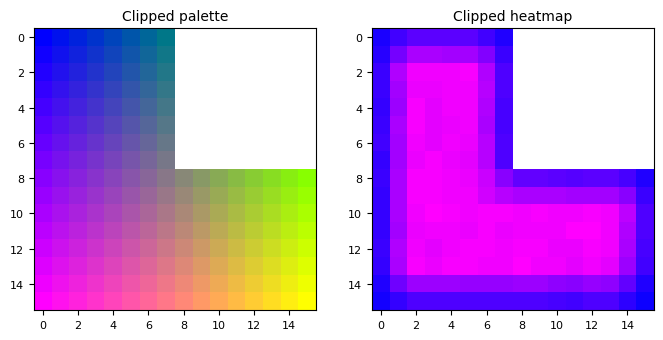

In [112]:
mask = np.reshape(Shape.copy(), -1)
# mask doit être transposé sur les index, pas les labels !!!

colorsMap_list_n = colors.copy().astype(int).reshape((256,3))[mask]/255.
colorsMap_list = colorsMap_list_n.tolist()

heatMap_list_n = E.copy().reshape((256,3))[mask]
heatMap_list = heatMap_list_n.tolist()

print (colorsMap_list_n.shape, heatMap_list_n.shape)

clipped_palette = colors.copy()
clipped_palette[~Shape] = 255.
clipped_heatMap = E.copy() * 255.
clipped_heatMap[~Shape] = 255.
plotPalettes([clipped_palette.astype(int), clipped_heatMap.astype(int)], 
                ["Clipped palette", "Clipped heatmap"], rows=1, cols=2, size=(8,4))

### Option 1 - raw data

In [116]:
# Full length dataset
Opt1 = np.zeros((N**2,len(groups)))
for col in range(len(groups)):
    for label in groups[col]:
        row = np.where(M.ravel()==label)
        Opt1[row,col] = 1

# clipping the dataset        
Opt1 = Opt1[mask]

print (Opt1.shape[1], "features")
print (np.mean(Opt1))
print (np.max(np.sum(Opt1, axis=1)))
print (Opt1.shape)

1000 features
0.025390625
39.0
(192, 1000)


### Option 2 - normalized data

In [117]:
# sum of each row == 1
Opt2 = np.ndarray(Opt1.shape)
for i in range(Opt2.shape[0]):
    Opt2[i,:] = Opt1[i,:]/np.sum(Opt1[i,:]) 
Opt2[Opt2>=0.999] = 1.
print (np.mean(Opt2))
print (np.max(np.sum(Opt2, axis=1)))
print (Opt2.shape)

# save it for later
saveDict = { 'data': Opt2.tolist(), 
            'colors': colorsMap_list, 
            'labels': M[Shape].tolist(),
            'targets': np.argwhere(Shape).tolist()}

import json
with open("datasets/generated/l-Shape_vectors.json", "w") as f:
    json.dump(saveDict, f)

0.0009999999999999998
1.0
(192, 1000)


### Option 3 - PCA reduction, 95% confidence

In [118]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95, random_state=42)
Opt3 = pca.fit_transform(Opt2.copy())
print (pca.n_components_, "features")
print (Opt3.shape)
print (pca.explained_variance_ratio_[:2])

131 features
(192, 131)
[0.05896885 0.04200002]


# 2. Manifold Learning (unsupervised)

In [119]:
from sklearn.manifold import MDS, Isomap, TSNE, SpectralEmbedding, LocallyLinearEmbedding

def getNDdata(Xtr, dim):
    
    mds = MDS(n_components=dim, random_state=42, normalized_stress=True, metric=False, n_init=10)
    X_mds = mds.fit_transform(Xtr)

    isomap = Isomap(n_components=dim, n_neighbors=4)
    X_isomap = isomap.fit_transform(Xtr)

    tsne = TSNE(n_components=dim, random_state=42, perplexity=10)
    X_tsne = tsne.fit_transform(Xtr)

    embedding1 = SpectralEmbedding(n_components=dim, n_neighbors=5)
    X_spectral1 = embedding1.fit_transform(Xtr)

    embedding2 = SpectralEmbedding(n_components=dim, affinity="rbf", n_neighbors=4)
    X_spectral2 = embedding2.fit_transform(Xtr*7.5)

    lle = LocallyLinearEmbedding(n_components=dim, n_neighbors=4, random_state=42)
    X_lle = lle.fit_transform(Xtr)
    
    return [X_mds, X_isomap, X_tsne, X_spectral1, X_spectral2, X_lle], ["MDS", "Isomap, nn=4", "t-SNE, p=10", "SpectralE NN=5", "SpectralE NBF (scaling)", "LLE N=4"]
    
def plotResults(list_X, titles, palette=colorsMap_list):
    
    plt.figure(figsize=(11,4))

    for subplot, title, X_red in zip((131, 132, 133), titles[:3], list_X[:3]):
        plt.subplot(subplot)
        plt.title(title, fontsize=10, loc="left")
        plt.scatter(X_red[:, 0], X_red[:, 1], c=palette, marker="o", sizes=[markersize for i in range(X_red.shape[0])])
        plt.xlabel("$z_1$", fontsize=10)
        if subplot == 131:
            plt.ylabel("$z_2$", fontsize=12, rotation=0)
        plt.grid(False)
        
    plt.show()

    plt.figure(figsize=(11,4))

    for subplot, title, X_red in zip((131, 132, 133), titles[3:], list_X[3:]):
        plt.subplot(subplot)
        plt.title(title, fontsize=10, loc="left")
        plt.scatter(X_red[:, 0], X_red[:, 1], c=palette, marker="o", sizes=[markersize for i in range(X_red.shape[0])])
        plt.xlabel("$z_1$", fontsize=10)
        plt.grid(False)
        
    plt.show()

def plotLines(images, titles, colors):
    
    for i in range(len(images)):
        plt.figure(figsize=(11,4))
        plt.title(titles[i], fontsize=10, loc='left')
        plt.axis(False)
        plt.margins(0)

        im = np.array(images[i])
        mask = np.argsort(im, axis=0)
        im2 = colors[mask].squeeze()
        im2 = np.expand_dims(im2, axis=0)

        plt.imshow(np.vstack((im2,im2,im2)))
    return

### Option 1 - unweighted data

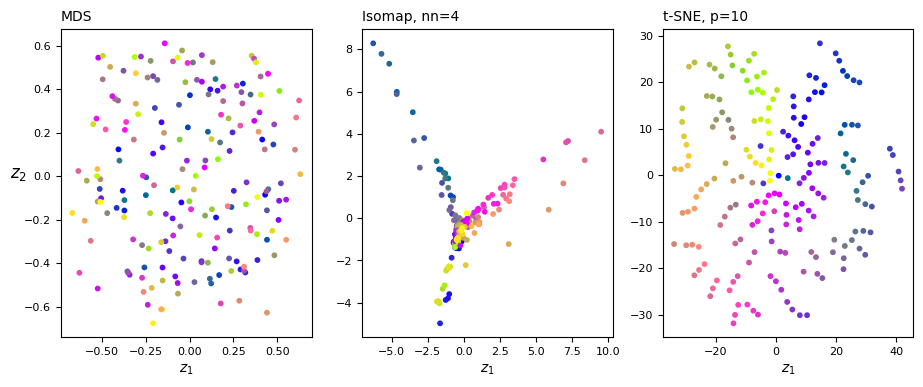

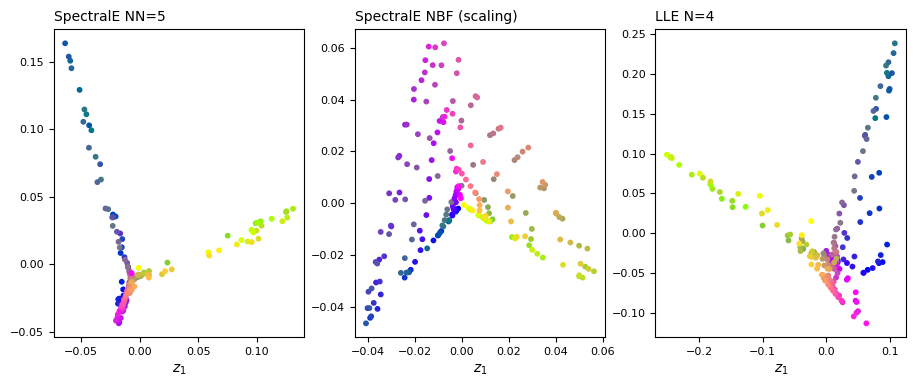

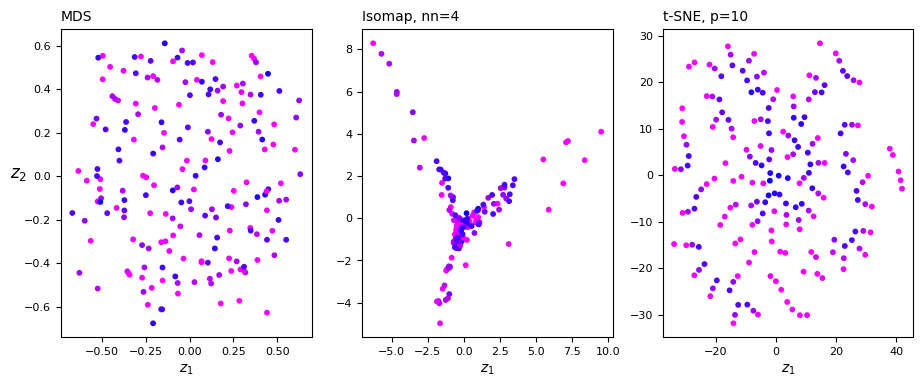

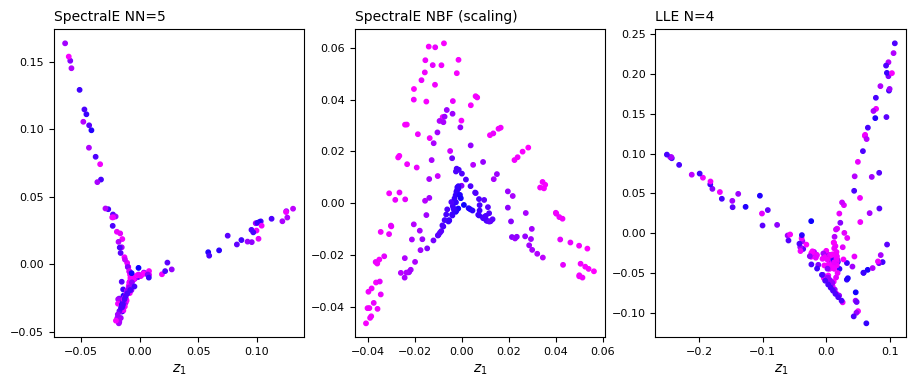

In [120]:
X_values_1, titles_1 = getNDdata(Opt1.copy(),2)
plotResults(X_values_1, titles_1)
plotResults(X_values_1, titles_1, palette=heatMap_list)

### Option 2 - normalized data

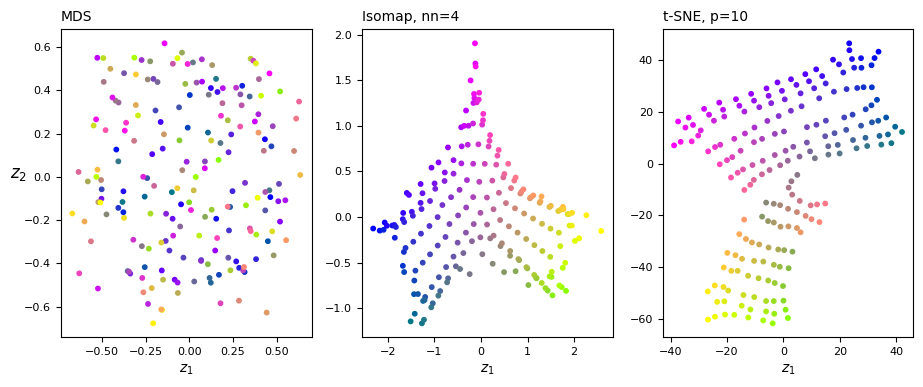

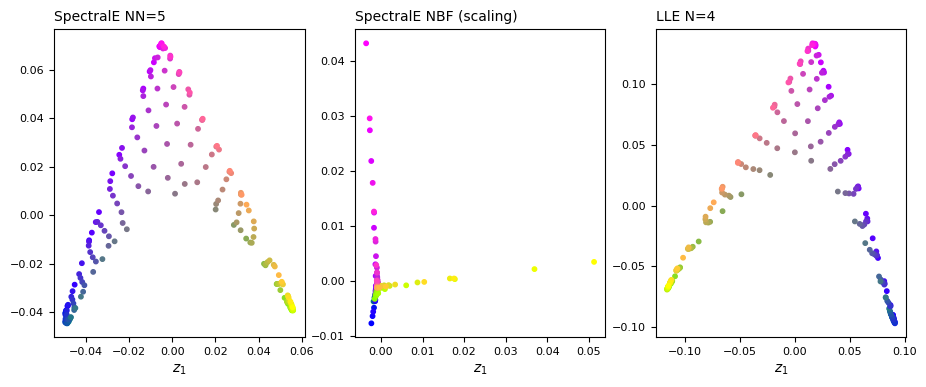

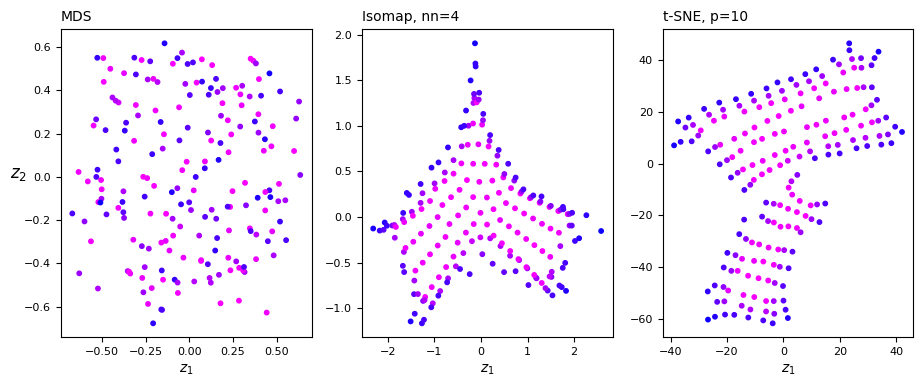

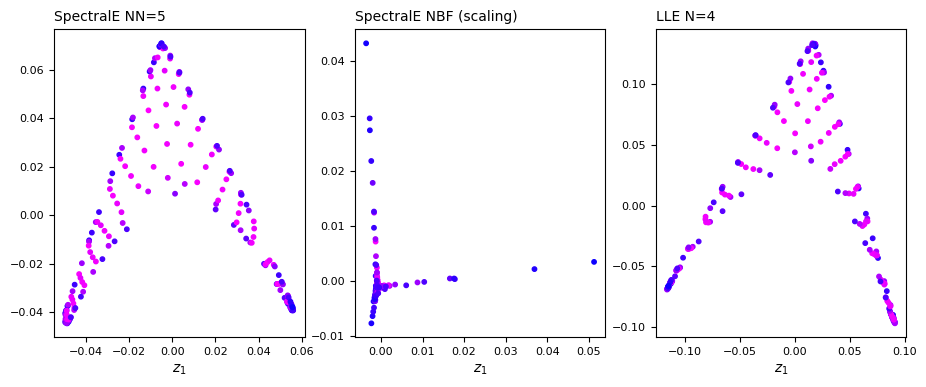

In [121]:
X_values_2, titles_2 = getNDdata(Opt2.copy(),2)
plotResults(X_values_2, titles_2)
plotResults(X_values_2, titles_2, palette=heatMap_list)

### Option 3 - after PCA reduction (95%)

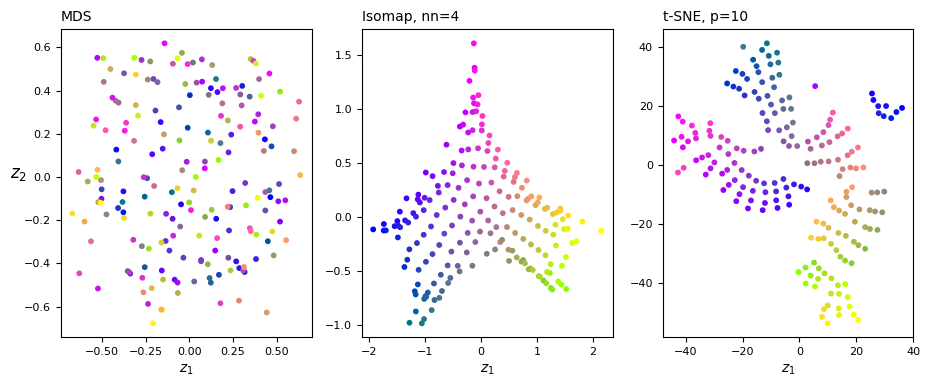

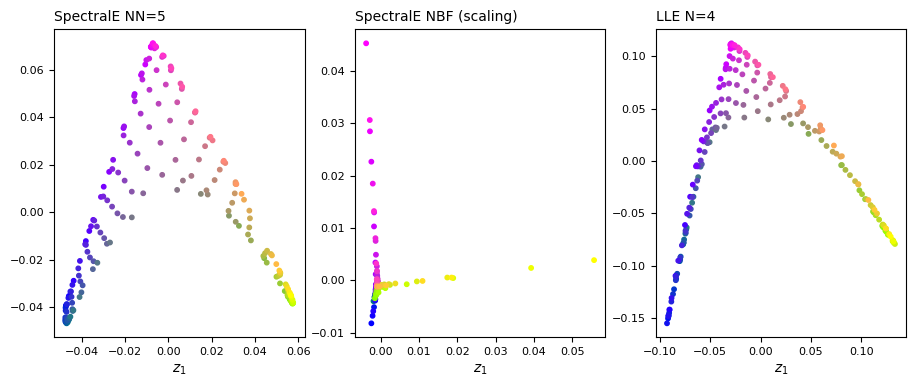

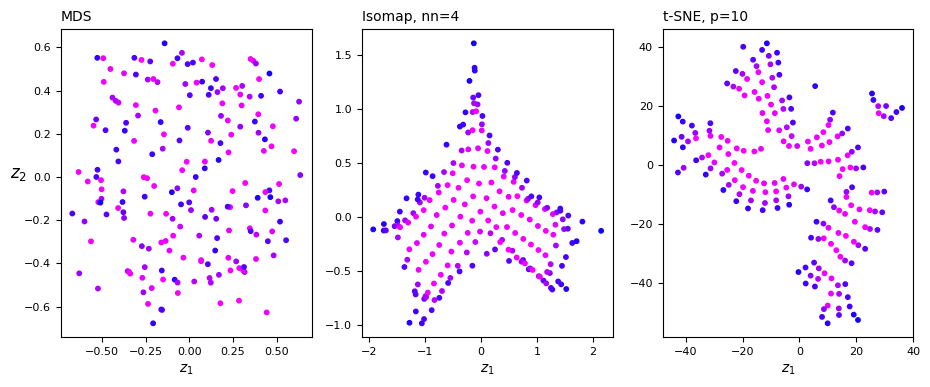

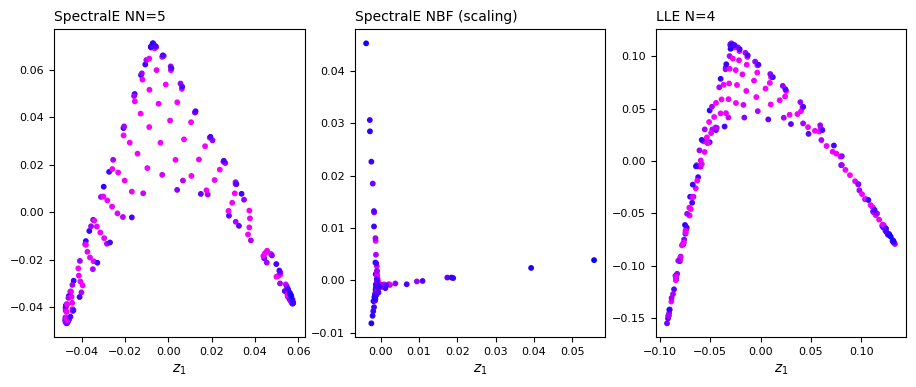

In [122]:
X_values_3, titles_3 = getNDdata(Opt3.copy(), 2)
plotResults(X_values_3, titles_3)
plotResults(X_values_3, titles_3, palette=heatMap_list)

# 3. Parameters tuning

### Tuning Isomap

In [144]:
Xtr = Opt2.copy()

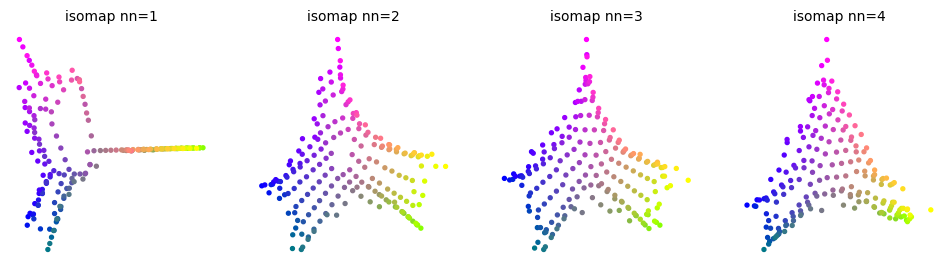

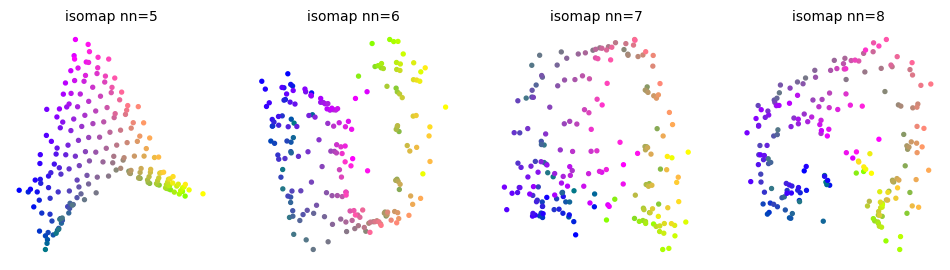

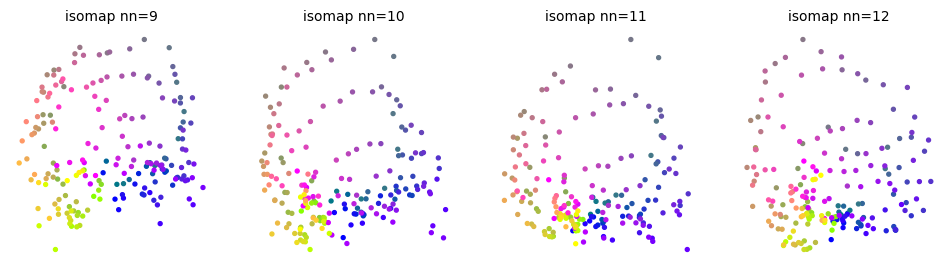

In [145]:
from sklearn.manifold import Isomap

X_coll = []
for i in range(2,14):
    isomap = Isomap(n_components=2, n_neighbors=i)
    X_isomap = isomap.fit_transform(Xtr.copy())
    X_coll.append(X_isomap)
    del X_isomap
    
for i in range(3):
    plt.figure(figsize=(12,3))    
    titles = ["isomap nn="+str(a) for a in range((4*i)+1,(4*i)+5)]
    for subplot, title, X_red in zip((141, 142, 143, 144), titles, tuple(X_coll[(4*i):(4*i)+4])):
        plt.subplot(subplot)
        plt.title(title, fontsize=10)
        plt.scatter(X_red[:, 0], X_red[:, 1], c=colorsMap_list, marker="o", sizes=[markersize-2 for i in range(X_red.shape[0])])
        plt.grid(False)
        plt.axis(False)
    plt.show()

### Tuning t-SNE

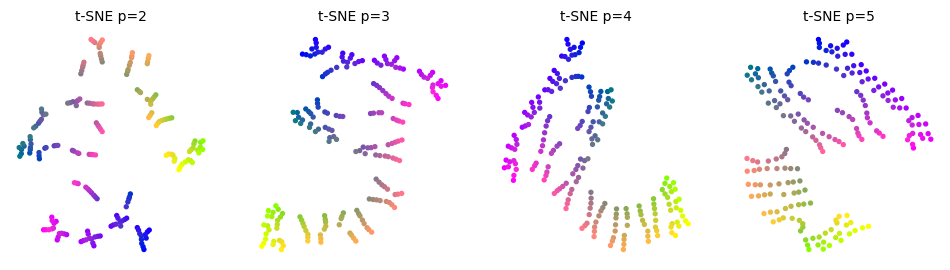

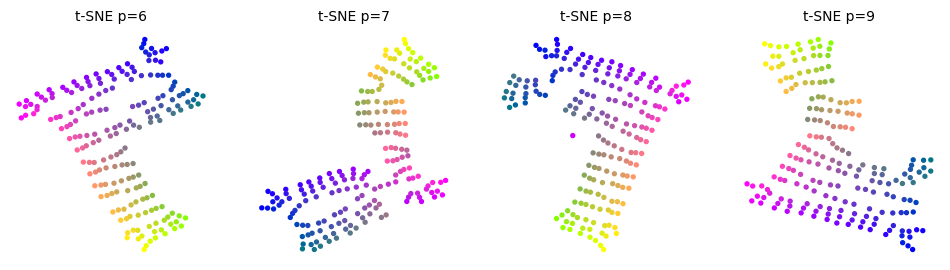

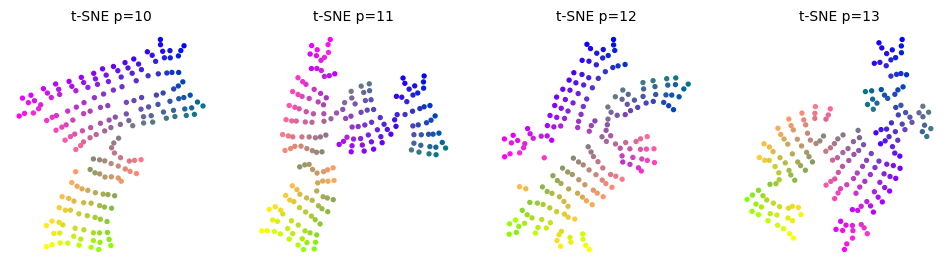

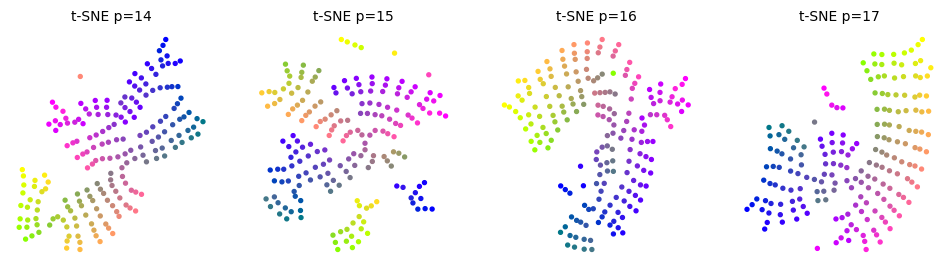

In [146]:
from sklearn.manifold import TSNE

X_coll = []
for i in range(2,18):
    tsne = TSNE(n_components=2, 
                random_state=42, perplexity=i, method="barnes_hut", 
                learning_rate="auto", early_exaggeration=12)
    X_tsne = tsne.fit_transform(Xtr)
    X_coll.append(X_tsne)
    
for i in range(4):
    plt.figure(figsize=(12,3))    
    titles = ["t-SNE p="+str(a+1) for a in range((4*i)+1,(4*i)+5)]
    for subplot, title, X_red in zip((141, 142, 143, 144), titles, tuple(X_coll[(4*i):(4*i)+4])):
        plt.subplot(subplot)
        plt.title(title, fontsize=10)
        plt.scatter(X_red[:, 0], X_red[:, 1], c=colorsMap_list, marker="o", sizes=[markersize-2 for i in range(X_red.shape[0])])
        plt.grid(False)
        plt.axis(False)
    plt.show()

### Tuning LLE Locally Linear Embedding

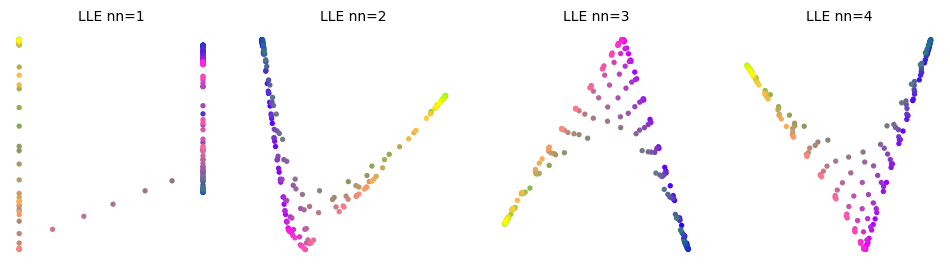

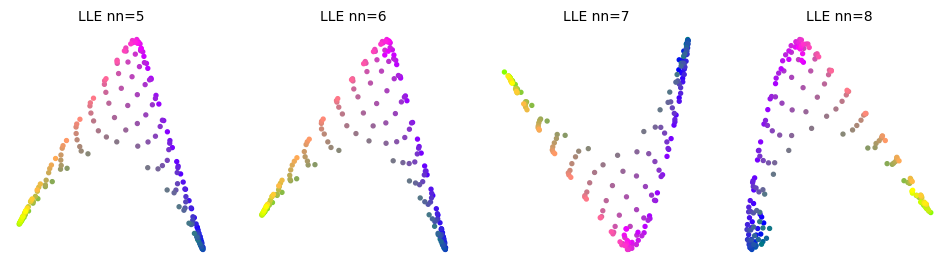

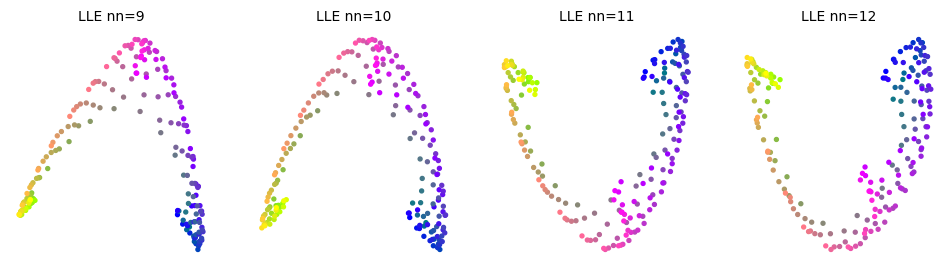

In [147]:
from sklearn.manifold import LocallyLinearEmbedding

X_coll = []
for i in range(2,14):
    isomap = LocallyLinearEmbedding(n_components=2, n_neighbors=i, random_state=42)
    X_lle = isomap.fit_transform(Xtr)
    X_coll.append(X_lle)
    
for i in range(3):
    plt.figure(figsize=(12,3))    
    titles = ["LLE nn="+str(a) for a in range((4*i)+1,(4*i)+5)]
    for subplot, title, X_red in zip((141, 142, 143, 144), titles, tuple(X_coll[(4*i):(4*i)+4])):
        plt.subplot(subplot)
        plt.title(title, fontsize=10)
        plt.scatter(X_red[:, 0], X_red[:, 1], c=colorsMap_list, marker="o", sizes=[markersize-2 for i in range(X_red.shape[0])])
        plt.grid(False)
        plt.axis(False)
    plt.show()

### Tuning Spectral Embedding

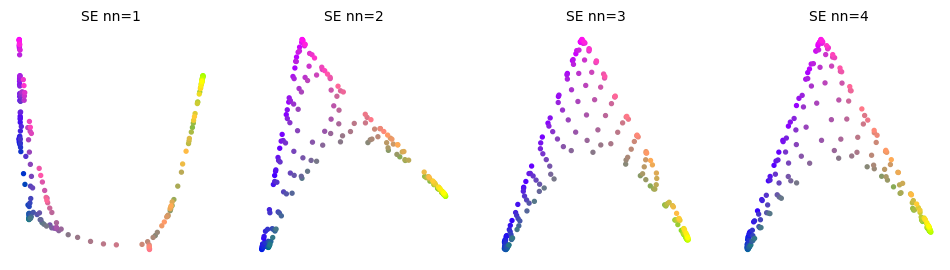

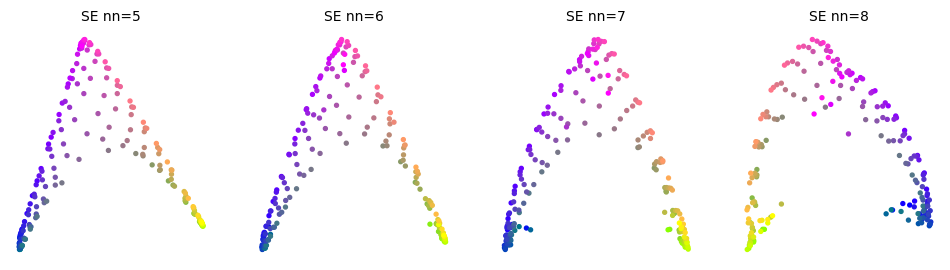

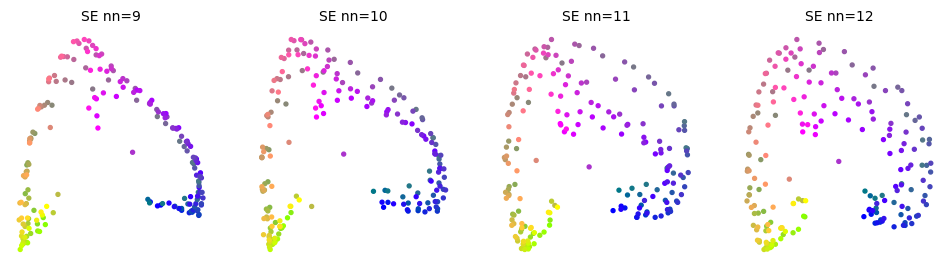

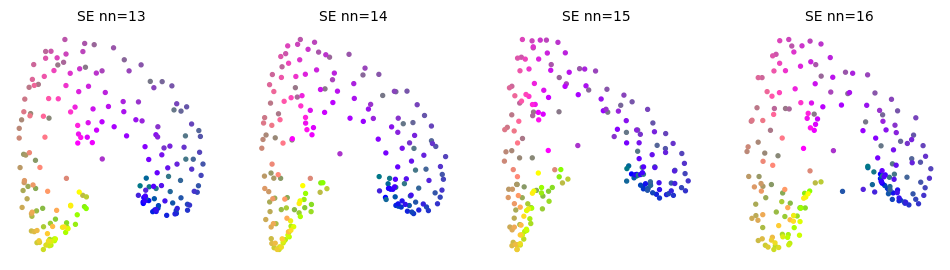

In [148]:
from sklearn.manifold import SpectralEmbedding

X_coll = []
for i in range(3,19):
    embedding = SpectralEmbedding(n_components=2, n_neighbors=i)
    X_embedding = embedding.fit_transform(Xtr)
    X_coll.append(X_embedding)
    
for i in range(4):
    
    plt.figure(figsize=(12,3))    
    titles = ["SE nn="+str(a) for a in range((4*i)+1,(4*i)+5)]
    for subplot, title, X_red in zip((141, 142, 143, 144), titles, tuple(X_coll[(4*i):(4*i)+4])):
        plt.subplot(subplot)
        plt.title(title, fontsize=10)
        plt.scatter(X_red[:, 0], X_red[:, 1], c=colorsMap_list, marker="o", sizes=[markersize-2 for i in range(X_red.shape[0])])
        plt.grid(False)
        plt.axis(False)
    plt.show()

# 4. One-dimensional outputs

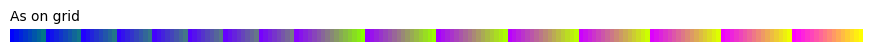

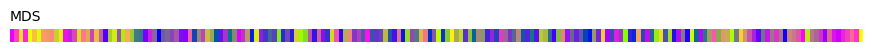

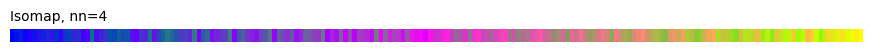

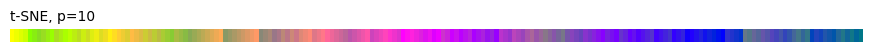

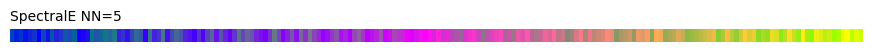

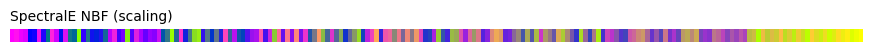

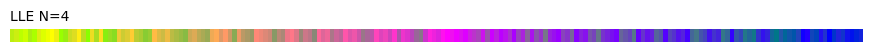

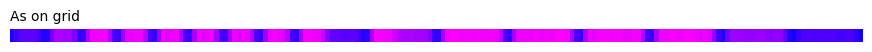

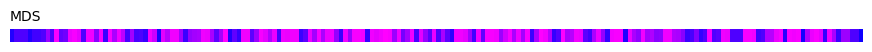

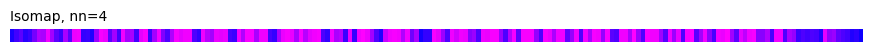

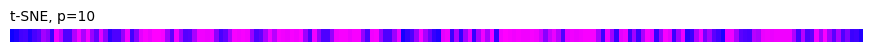

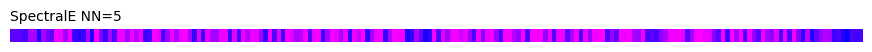

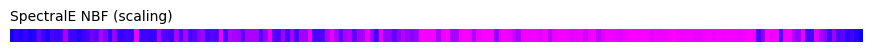

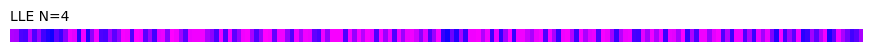

In [136]:
X_values_2_1, titles_2_1 = getNDdata(Opt2.copy(), 1)   

plotLines([np.arange(len(colorsMap_list_n))], ["As on grid"], colorsMap_list_n)
plotLines(X_values_2_1, titles_2_1, colorsMap_list_n)

plotLines([np.arange(len(colorsMap_list_n))], ["As on grid"], heatMap_list_n)
plotLines(X_values_2_1, titles_2_1, heatMap_list_n)

## Conclusive statements
- Manifold Learning, when trained with normalized data and tuned correctly, can approximate not just the location of each item with regard to its neighbors, but provides as well <b>an organic replica that echoes the original 2-d shape</b> - it is especially obvious with the t-SNE model ; 
- Training data was shuffled prior training in order to prevent <b>knowledge transfer</b> ;
- Some of the previous algorithms rely mostly on <b>Eigenvectors</b> - simply using Eigenvectors could lead to similar results&nbsp;;
- At first sight, one-dimensional outputs don't seem to carry much phase information.

## Next steps
- How do we <b>transpose</b> the organic Manifold outputs into integer (x,y) coordinates, matching the original grid ?